In [2]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics

# data

In [65]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


#### LED OFF #####
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# remove ILD 16, -16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]
print(f'len of ILD 16 removed: {len(df_led_off)}')

len of LED off: 66226
len of ILD 16 removed: 53059


In [66]:
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of led off valid trials = 42763
len of valid trials < 1s : 42096


# loglike fn

In [6]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
t_E_aff = 0.075
del_go = 0.12

Z_E = 0
K_max = 10

# LED off - no noise
rate_lambda = 0.12
noise = 0

In [7]:
def compute_loglike_trial(row, rate_lambda, T_0, theta_E, noise):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    # TEMP: simulated data check
    # rt = row['rt']
    # t_stim = row['t_stim']
    # t_LED = row['t_led']

    ABL = row['ABL']
    ILD = row['ILD']

    response_poke = row['response_poke']
    # TEMP: simulated data check
    # response_poke = 3 if row['choice'] == 1 else 2

    

    t_pts = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts)
    trunc_factor = area_btn_stim_and_1s
        
    if response_poke == 3:
        # up
        likelihood = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                        ABL, ILD, rate_lambda, T_0, noise,\
                                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
    elif response_poke == 2:
        # down
        likelihood = down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                        ABL, ILD, rate_lambda, T_0, noise,\
                                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)


    likelihood /= (trunc_factor + 1e-10)
        
    if likelihood <= 0:
        likelihood = 1e-50


    return np.log(likelihood)


def vbmc_loglike_fn(params):
    # rate_lambda, T_0, theta_E = params
    T_0, theta_E = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, rate_lambda, T_0, theta_E, noise) \
                                     for _, row in df_led_off_valid_trials.iterrows())
    
    return np.sum(all_loglike)

# bounds

In [8]:
# rate_lambda_bounds = [0.01, 0.2]
# rate_lambda_plausible_bounds =  [0.08, 0.15]

### close to eye fit ###
# theta_E_bounds = [35, 55] # 45
# theta_E_plausible_bounds = [40, 50]

# # 0.45
# T_0_bounds = [0.35 * (1e-3), 0.55 * (1e-3)]
# T_0_plausible_bounds = [0.4 * (1e-3), 0.5 * (1e-3)]


### regular bounds ###
theta_E_bounds = [20, 80]
theta_E_plausible_bounds = [40, 50]

T_0_bounds = [0.1 * (1e-3), 5 * (1e-3)]
T_0_plausible_bounds = [0.6 * (1e-3), 1.5 * (1e-3)]

# priors

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    # rate_lambda, T_0, theta_E = params
    T_0, theta_E = params

    # rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])

    return T_0_logpdf + theta_E_logpdf

# prior + loglike

In [10]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [11]:
# lb = np.array([rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0]])
# ub = np.array([rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1] ])

# plb = np.array([rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0]])
# pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1]])

lb = np.array([T_0_bounds[0], theta_E_bounds[0]])
ub = np.array([T_0_bounds[1], theta_E_bounds[1] ])

plb = np.array([T_0_plausible_bounds[0], theta_E_plausible_bounds[0]])
pub = np.array([T_0_plausible_bounds[1], theta_E_plausible_bounds[1]])

np.random.seed(42)

# rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
### regular init ###
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

### close to eye fit ###
# T_0_0 = 0.45 * (1e-3)
# theta_E_0 = 45

# x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0])
x_0 = np.array([T_0_0, theta_E_0])


vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       33458.20      1049.72          inf        2        inf     start warm-up
     1         15       33837.76        17.71      2961.36        2        inf     
     2         20       33833.77         0.10        20.00        2        485     
     3         25       33833.76         0.00         0.00        2      0.138     
     4         30       33833.73         0.00         0.01        2      0.376     
     5         35       33833.77         0.00         0.01        2      0.361     
     6         40       33833.72         0.00         0.04        2       1.14     
     7         45       33833.74         0.0

In [ ]:
# vbmc.save('added_noise_vbmc.pkl', overwrite=True)

In [ ]:
# import pickle 
# with open('added_noise_vbmc.pkl', 'rb') as f:
#     vp = pickle.load(f)


# vp = vp.vp

# corner and diagnostics

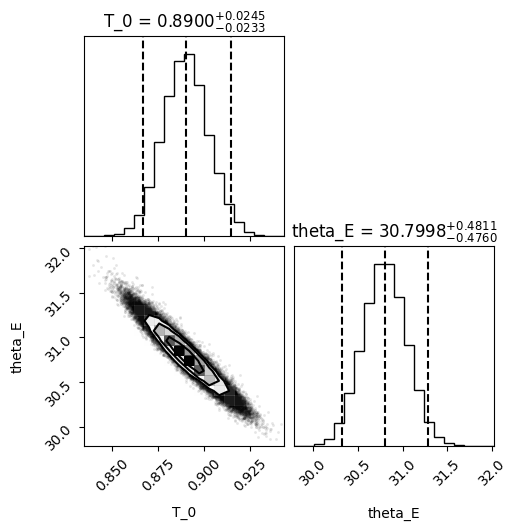

In [12]:
vp_samples = vp.sample(int(1e5))[0]

vp_samples[:, 0] *= 1e3
param_labels = [ 'T_0', 'theta_E']
percentiles = np.percentile(vp_samples, [0, 100], axis=0)


_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    # truths=true_arr,
    title_fmt=".4f"
);

vp_samples[:, 0] *= 1e-3

# design diagnostics

In [13]:
import os
def psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, \
                                t_stim_and_led_tuple, new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, del_go, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # random element from t_stim_and_led_tuple
    t_stim, t_led = t_stim_and_led_tuple

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'os id: {os.getpid()}, In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')

    choice, rt, is_act = simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim, 't_led': t_led, 'is_LED_trial': is_LED_trial}

def simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt):
    AI = 0; DV = Z_E; t = t_A_aff; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e

    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )

    # firing rates decrease
    new_T0 = T_0 * T0_factor
    # mu changes with firing rate
    new_mu = (2*q_e/new_T0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    # sigma changes with firing rate
    new_sigma = np.sqrt( (2*(q_e**2)/new_T0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    new_sigma = np.sqrt(new_sigma**2 + new_noise**2)

    is_act = 0
    while True:
        if t >= t_led and is_LED_trial:
            mu = new_mu
            sigma = new_sigma
            V_A = new_V_A
        
        AI += V_A*dt + np.random.normal(0, dB)

        if t > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t
            break
        elif DV <= -theta:
            choice = -1; RT = t
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            did_EA_hit = 0
            # if t*dt > t_stim - t_motor:
            while t <= (AI_hit_time + del_go):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    if t >= t_led and is_LED_trial:
                        mu = new_mu
                        sigma = new_sigma
                        V_A = new_V_A

                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        did_EA_hit = 1
                        break
                    elif DV <= -theta:
                        DV = -theta
                        did_EA_hit = -1
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time
        if did_EA_hit == 0:
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1
        else:
            choice = did_EA_hit
               
    
    return choice, RT, is_act



In [14]:
# rate_lambda_mean = np.mean(vp_samples[:, 0])
T_0_mean = np.mean(vp_samples[:, 0])
theta_E_mean = np.mean(vp_samples[:, 1])

print(f'T_0 = {T_0_mean*1000} ms, theta_E = {theta_E_mean}')

T_0 = 0.8900893454049942 ms, theta_E = 30.800233833604512


In [53]:
# sim
noise_mean = 0

N_sim = int(1e6)
N_print = int(N_sim/5)
is_LED_trial = True
dt = 1e-4

sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                                        rate_lambda, T_0_mean, theta_E_mean, Z_E, \
                                                                                            t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple_samples[iter_num], \
                                                                        V_A_post_LED, noise_mean, 1, iter_num, N_print, is_LED_trial, del_go, dt) \
                                                                              for iter_num in tqdm(range(N_sim)))


  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1734607, In iter_num: 0, ABL: 40, ILD: 2.0, t_stim: 0.427191588410809
os id: 1734636, In iter_num: 200000, ABL: 60, ILD: -8.0, t_stim: 0.649784449866862
os id: 1734615, In iter_num: 400000, ABL: 40, ILD: -1.0, t_stim: 0.468471682324622
os id: 1734626, In iter_num: 600000, ABL: 60, ILD: -8.0, t_stim: 1.35996513210461
os id: 1734635, In iter_num: 800000, ABL: 40, ILD: -4.0, t_stim: 0.629700558669863


In [54]:
import pickle
with open('compare_theory_with_juan_sim_results.pkl', 'wb') as f:
    pickle.dump(sim_results, f)

In [67]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = sim_results_df.apply(
    lambda row: 1 if row['ILD'] * row['choice'] > 0 else 0,
    axis=1
)

# > 1s are removed 
sim_results_df = sim_results_df[sim_results_df['rt'] - sim_results_df['t_stim'] < 1] 

# remove aborts < 0.3
sim_results_df_with_aborts = sim_results_df[ ~( (sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3) ) ]
sim_results_df_valid = sim_results_df_with_aborts[ (sim_results_df_with_aborts['rt'] > sim_results_df_with_aborts['t_stim']) ]

In [68]:
# add back ILD 16
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

len of LED off: 66226


In [69]:
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

In [70]:
sim_diag_with_aborts = Diagnostics(sim_results_df_with_aborts)
sim_diag_valid = Diagnostics(sim_results_df_valid)

data_diag_with_aborts = Diagnostics(data_df_led_off_with_aborts)
data_diag_valid = Diagnostics(data_df_led_off_valid)

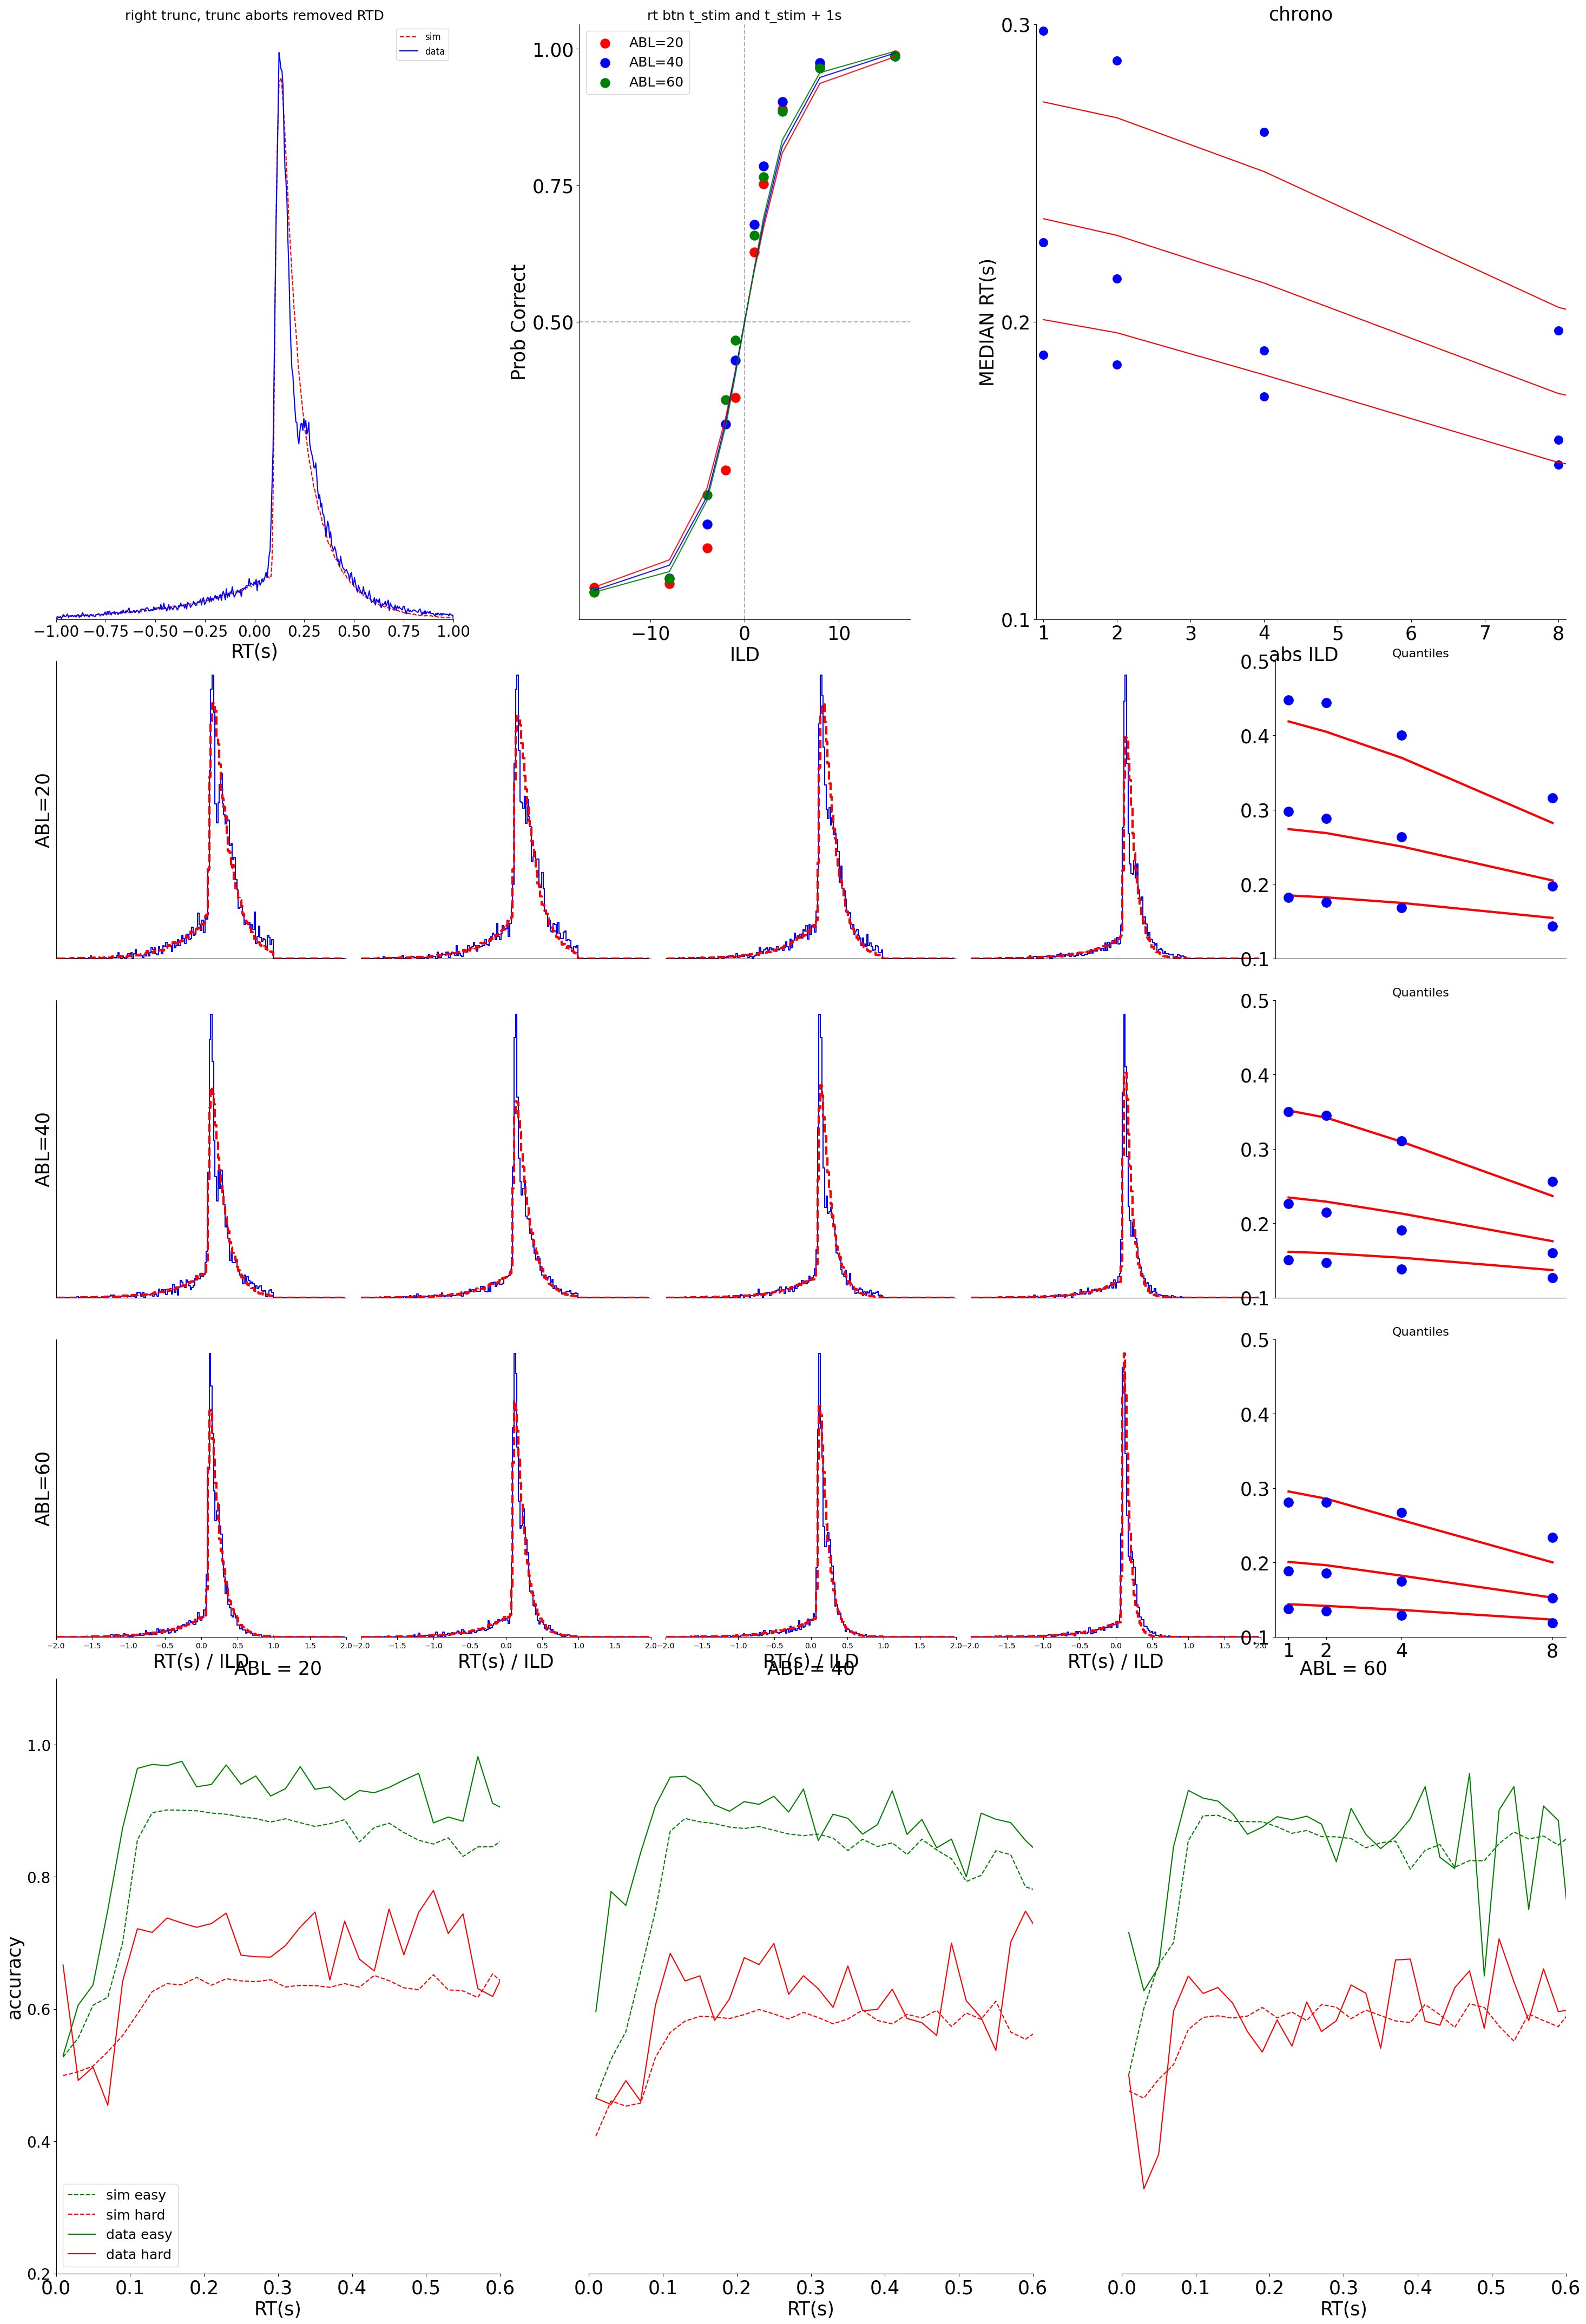

In [71]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-2, 2, 0.005)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-1,1)
ax_rtd.set_ylim(bottom=0)

### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
ax_psy.axvline(0, color='k', ls='--', alpha=0.3)
ax_psy.axhline(0.5, color='k', ls='--', alpha=0.3)

### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color='r')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color='b', marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.4, 0.1))
ax_chrono.set_ylim(0.1, 0.3)

### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(-2, 2, 0.02)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            # sim_pd = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin([ILD, -ILD]))]
            sim_pd = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            # data_pd = data_df_led_off_valid[(data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin([ILD, -ILD]))]
            data_pd = data_df_led_off_with_aborts[(data_df_led_off_with_aborts['ABL'] == ABL) & (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=3)
        
            if a == len(ABL_arr) - 1:
                ax.set_xlabel('RT(s) / ILD', fontsize=25)
            if j == 0:
                ax.set_ylabel(f'ABL={ABL}', fontsize=25)
                ax.tick_params(axis='y', which='major', labelsize=20)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            if j != 0:
                ax.spines['left'].set_visible(False)

            ax.set_yticks([])
            ax.set_xlim(-2,2)
            ax.set_ylim(bottom=0)



        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD[:-1], sim_qs[:-1,:], lw=3,color='r')
            ax.plot(all_pos_ILD[:-1], data_qs[:-1,:], linestyle='', marker='.', markersize=25, color='b')
            ax.set_title('Quantiles', fontsize=16)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
        
            # increase font size of x-axis labels
            ax.tick_params(axis='x', which='major', labelsize=25)
            ax.tick_params(axis='y', which='major', labelsize=25)
            ax.set_ylim(0.1, 0.5)
            ax.set_yticks(np.arange(0.1, 0.6, 0.1))
            ax.set_xticks(all_pos_ILD[:-1])
        # Format spines
        
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

# hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
hard_ILD = np.array([1, -1, 2, -2]); easy_ILD = np.array([4, -4, 8, -8])

bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_off_valid[ (data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_off_valid[ (data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)




# RTDs check?

In [ ]:
# sim_pd = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin([ILD, -ILD]))]
# sim_rt = sim_pd['rt'] - sim_pd['t_stim']

# # data_pd = data_df_led_off_valid[(data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin([ILD, -ILD]))]
# data_pd = data_df_led_off_with_aborts[(data_df_led_off_with_aborts['ABL'] == ABL) & (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))]
# data_rt = data_pd['rt'] - data_pd['t_stim']

# sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
# data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
# t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

# ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
# ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=3)

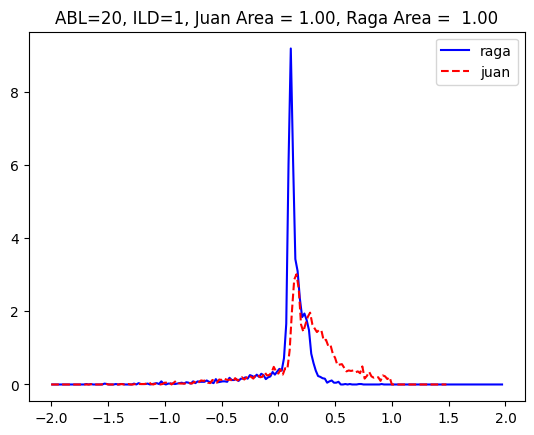

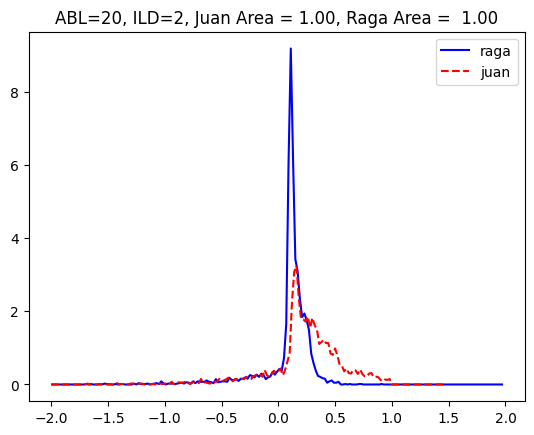

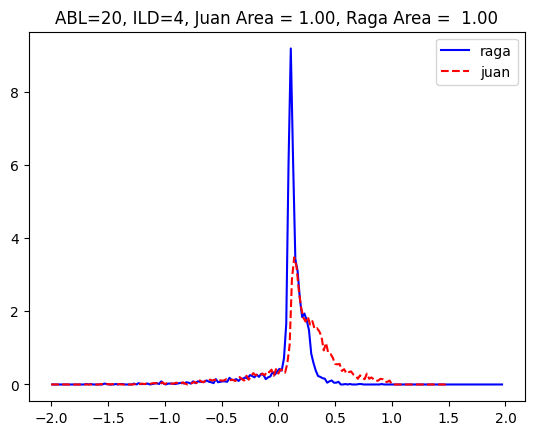

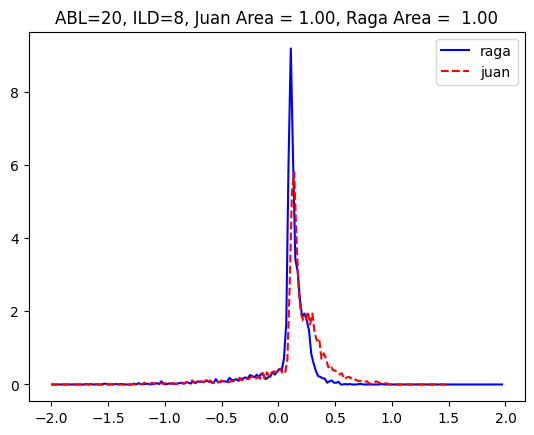

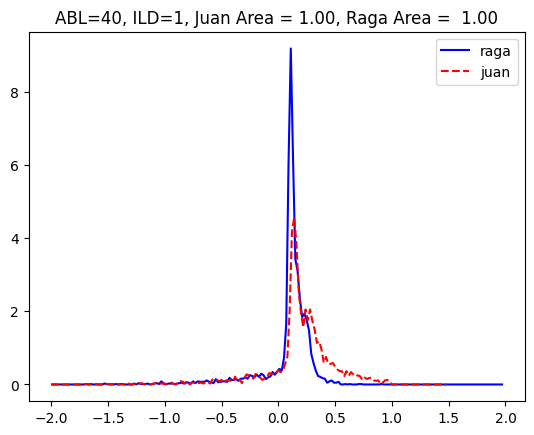

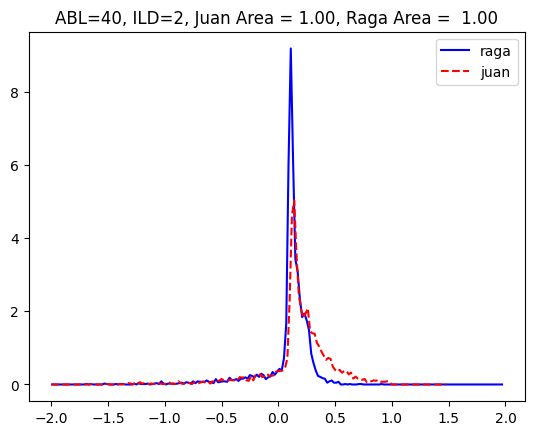

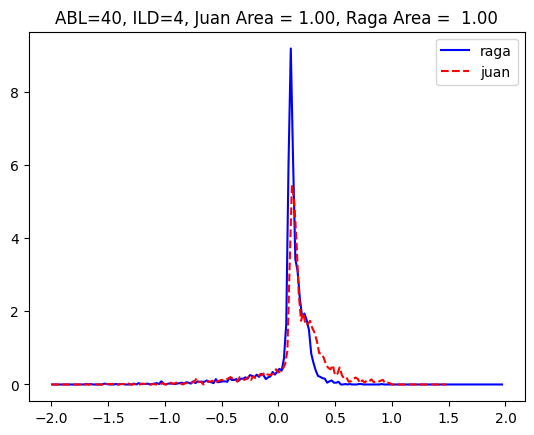

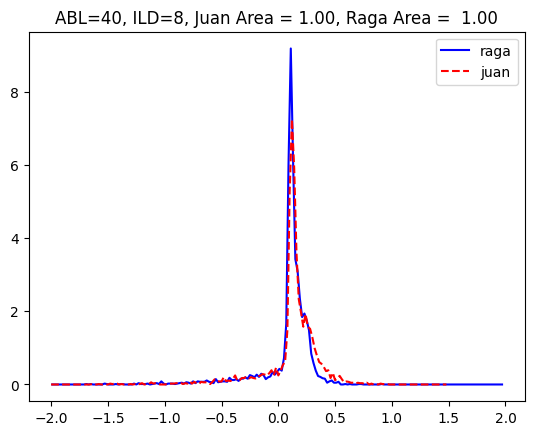

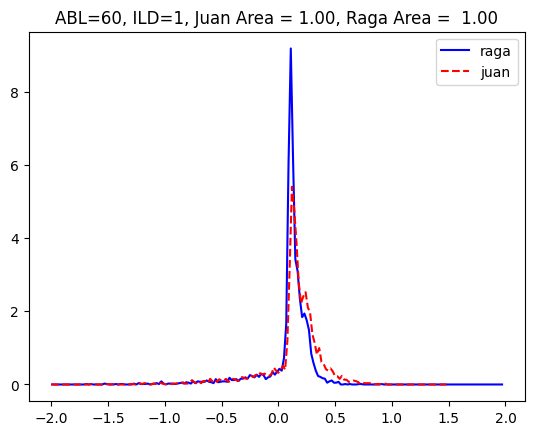

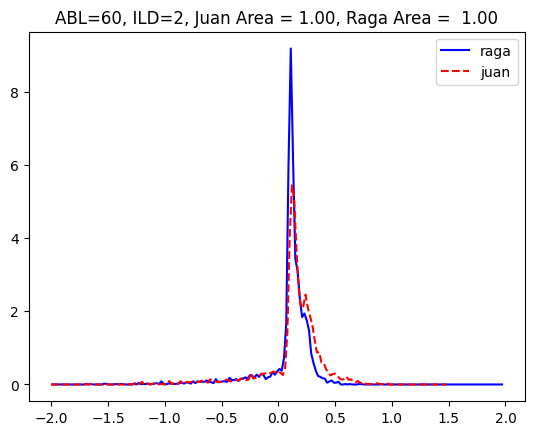

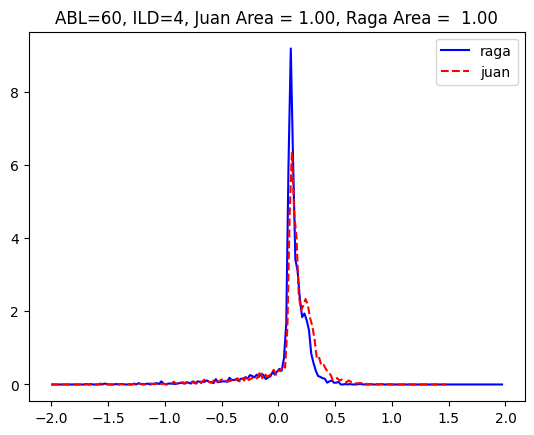

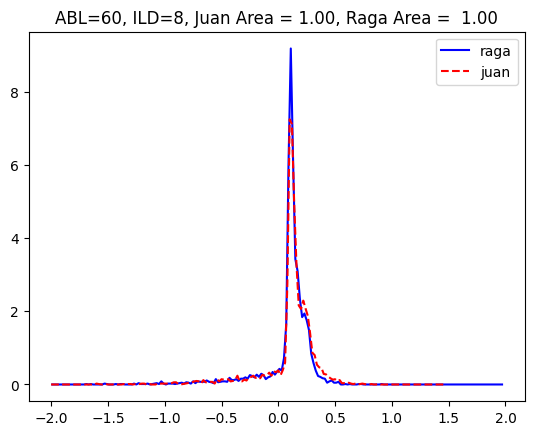

In [49]:
import scipy.io

# Load the .mat file
data = scipy.io.loadmat('hist_data.mat')

# Assuming your .mat file contains variables 'xx' and 'hcs'
xx = data['xx'].squeeze()  # Ensure xx is a 1D array
hcs = data['hcs']          # hcs might be a 2D array or a cell-like structure

ABL_test = [20, 40, 60]
ILD_test = [1, 2, 4, 8]

for ABL_i in range(3):
    for ILD_i in range(4):
        data_pd = data_df_led_off_with_aborts[(data_df_led_off_with_aborts['ABL'] == ABL) & (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']
        bins = np.arange(-2, 2, 0.02)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)

        plt.figure()
        # mine
        plt.plot(t_pts, data_rt_hist, label=f'raga', color='b')
        # Juan
        plt.plot(xx[:-1], hcs[ABL_i, ILD_i].squeeze(), color='r', ls='--', label='juan')
        plt.legend()
        
        area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx[:-1])
        area_raga = trapz(data_rt_hist, t_pts)
        
        plt.title(f'ABL={ABL_test[ABL_i]}, ILD={ILD_test[ILD_i]}, Juan Area = {area_juan:.2f}, Raga Area = {area_raga: .2f}')

        plt.show()


In [34]:
hcs.shape

(3, 4)

# likelihood of data

In [26]:
print(f'vbmc even after starting with best and narrow bounds like: {vbmc_loglike_fn([T_0_mean, theta_E_mean])}')

vbmc even after starting with best and narrow bounds like: 33844.91850472504


In [ ]:
# vbmc_loglike_fn([0.45 * 1e-3, 45])
print(f'eye fit params like: {vbmc_loglike_fn([0.45*1e-3, 45])}')


In [ ]:
print(f'Old vbmc with random init like: {vbmc_loglike_fn([0.93*1e-3, 30.95])}')


# is likelihood correct?

In [ ]:
# sim_results_df_valid
up_rts_df = sim_results_df_valid[sim_results_df_valid['choice'] == 1]
down_rts_df = sim_results_df_valid[sim_results_df_valid['choice'] == -1]

up_rts = up_rts_df['rt'] 
down_rts = down_rts_df['rt']

frac_of_up = len(up_rts) / len(sim_results_df_valid)
frac_of_down = len(down_rts) / len(sim_results_df_valid)

In [ ]:
# N_sample = int(1e3)
# sample_indices = np.random.choice(len(df_led_off), N_sample)
# t_pts = np.arange(0, 1, 0.005)

# up_pdf_samples = np.zeros((N_sample, len(t_pts)))
# down_pdf_samples = np.zeros((N_sample, len(t_pts)))

# for samp_idx in tqdm(range(len(sample_indices))):
#     sample_row = df_led_off.iloc[sample_indices[samp_idx]]
#     t_stim = sample_row['intended_fix']
#     t_LED = sample_row['intended_fix'] - sample_row['LED_onset_time']
#     ABL = sample_row['ABL']
#     ILD = sample_row['ILD']
    
#     up_pdf_samples[samp_idx, :] = np.array([up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(i, t_LED, V_A, V_A_post_LED, theta_A, \
#                                                             ABL, ILD, rate_lambda, T_0_mean, noise_mean,\
#                                                             theta_E_mean, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max) for i in t_pts])
#     down_pdf_samples[samp_idx, :] = np.array([down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(i, t_LED, V_A, V_A_post_LED, theta_A, \
#                                                                         ABL, ILD, rate_lambda, T_0_mean, noise_mean,\
#                                                                 theta_E_mean, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max) for i in t_pts])


N_sample = int(5e3)
sample_indices = np.random.choice(len(df_led_off), N_sample)
t_pts = np.arange(0, 2, 0.01)

def compute_pdfs(samp_idx):
    sample_row = df_led_off.iloc[sample_indices[samp_idx]]
    t_stim = sample_row['intended_fix']
    t_LED = sample_row['intended_fix'] - sample_row['LED_onset_time']
    ABL = sample_row['ABL']
    ILD = sample_row['ILD']
    
    up_pdf = np.array([
        up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(i, t_LED, V_A, V_A_post_LED, theta_A,
                                                              ABL, ILD, rate_lambda, T_0_mean, noise_mean,
                                                              theta_E_mean, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
        for i in t_pts
    ])
    
    down_pdf = np.array([
        down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(i, t_LED, V_A, V_A_post_LED, theta_A,
                                                                ABL, ILD, rate_lambda, T_0_mean, noise_mean,
                                                                theta_E_mean, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
        for i in t_pts
    ])
    
    return up_pdf, down_pdf

# Process the samples in parallel using 30 jobs.
results = Parallel(n_jobs=30)(
    delayed(compute_pdfs)(samp_idx) for samp_idx in tqdm(range(len(sample_indices)))
)

# Unpack the results into the respective arrays.
up_pdf_samples = np.vstack([res[0] for res in results])
down_pdf_samples = np.vstack([res[1] for res in results])


In [ ]:
up_pdf_samples_mean = np.mean(up_pdf_samples, axis=0)
down_pdf_samples_mean = np.mean(down_pdf_samples, axis=0)

In [ ]:
# data
bins = np.arange(0, 2, 0.05)
sim_hist_up, _ = np.histogram(up_rts, bins=bins, density=True)
sim_hist_down, _ = np.histogram(down_rts, bins=bins, density=True)

sim_hist_up *= frac_of_up
sim_hist_down *= frac_of_down

bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

plt.plot(bin_centers, sim_hist_up, label='sim up', color='r')
plt.plot(bin_centers, -sim_hist_down, label='sim down', color='b')

# sim
plt.plot(t_pts, up_pdf_samples_mean, label='sim up pdf', color='r', ls='--')
plt.plot(t_pts, -down_pdf_samples_mean, label='sim down pdf', color='b', ls='--')
plt.legend()


# area
up_area = trapz(sim_hist_up, bin_centers)
down_area = trapz(sim_hist_down, bin_centers)
print(f'up area: {up_area:.2f}, down area: {down_area: .2f}')

print(f'sim areas up = {trapz(up_pdf_samples_mean, t_pts):.2f}, down = {trapz(down_pdf_samples_mean, t_pts):.2f}')


# checking delta go issue?

In [ ]:

# N_sim = int(100e3)

# dt = 1e-3
# plt.figure(figsize=(12, 8))
# delta_go_test_arr = [0.12, 0.15, 0.19, 1.5]
# # delta_go_test_arr = [0.12]

# bins = np.arange(-2, 2, 0.005)
# for go_test in delta_go_test_arr:
#     sim_results_go_test = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO)(V_A, theta_A, ABL_arr, ILD_arr,\
#                                                                                         rate_lambda, T_0_mean, theta_E_mean, Z_E, \
#                                                                                             t_A_aff, t_E_aff,\
#                                                                                     t_stim_and_led_tuple_samples[iter_num], \
#                                                                         V_A_post_LED, noise_mean, 1, iter_num, N_print, is_LED_trial, go_test, dt) \
#                                                                               for iter_num in tqdm(range(N_sim)))
    
#     all_test_df = pd.DataFrame(sim_results_go_test)

#     # tacho
#     all_test_df['correct'] = all_test_df.apply(
#         lambda row: 1 if row['ILD'] * row['choice'] > 0 else 0,
#         axis=1
#     )
#     test_diag = Diagnostics(all_test_df)

#     bins = np.arange(0, 2, 0.02)
#     x, y = test_diag.plot_tacho(bins)
#     plt.plot(x, y, label=f'go test={go_test}')

#     # all_test_rt = all_test_df['rt'] - all_test_df['t_stim']
#     # plt.hist(all_test_rt, bins=bins, density=True, alpha=0.5, label=f'go_test={go_test}', histtype='step')

# plt.legend()
# plt.xlabel('rt - t_stim')
# plt.ylabel('density')